# Cryto Modelling

## Modelling on larger data set

In [49]:
%matplotlib inline

In [48]:
import os
import numpy as np
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.model_selection import train_test_split
import gc
import matplotlib.pyplot as plt

In [5]:
path = 'crypto_data/'

### Reshape the to get the training data
Stateful and stateless LSTM reference:

https://machinelearningmastery.com/stateful-stateless-lstm-time-series-forecasting-python/
http://philipperemy.github.io/keras-stateful-lstm/

#### Trainging data is the relatively change over the first price of the day

In [60]:
def create_input(dat, window_len=3):
    # input dat: data frame
    # output train_X: array (samples, time_step, num_features)
    # output train_y: array labels(close price)
    train_X = []
    train_y = []
    dat = dat.sort_values(by='Date').reset_index(drop=True)
    dat = dat.drop('Date', axis=1)
    cols = dat.columns
    for i in range(len(dat)-window_len):
        temp_dat = dat[i:(i+window_len)].copy().reset_index(drop=True)
        # normalize data by computing the increase percentage: (X2-X1)/X1
        for col in cols:
            temp_dat[col] = temp_dat[col]/temp_dat.loc[0, col] - 1
        train_X.append(temp_dat)
        # increase percentage of Close price
        train_y.append(dat.loc[(i+window_len), 'Close']/dat.loc[i, 'Close'] - 1)
    # convert data set to array
    train_X = [np.array(train_X[i]) for i in range(len(train_X))]
    train_y = [np.array(train_y[i]) for i in range(len(train_y))]
    return np.array(train_X), np.array(train_y)

### Wrap up in a class

In [26]:
class crypto():
    def __init__(self):
        self.train_X = []
        self.train_y = []
    
    def create_input(self, dat, window_len=3):
        # input dat: data frame
        # output train_X: array (samples, time_step, num_features)
        # output train_y: array labels(close price)
        dat = dat.sort_values(by='Date').reset_index(drop=True)
        dat = dat.drop('Date', axis=1)
        cols = dat.columns
        for i in range(len(dat)-window_len):
            temp_dat = dat[i:(i+window_len)].copy().reset_index(drop=True)
            # normalize data by computing the increase percentage: (X2-X1)/X1
            for col in cols:
                temp_dat[col] = temp_dat[col]/temp_dat.loc[0, col] - 1
            self.train_X.append(temp_dat)
            # increase percentage of Close price
            self.train_y.append(dat.loc[(i+window_len), 'Close']/dat.loc[i, 'Close'] - 1)
    
    def read_file(self, path, window_len=3):
        for root, dirs, files in os.walk(path):
            for file in files:
                print 'Processing file', file
                dat = pd.read_csv(os.path.join(path, file))
                dat.drop(dat.columns[0], axis=1, inplace=True)  # drop index
                try:
                    self.create_input(dat, window_len=window_len)  
                except:
                    print 'Error file', file
                    pass
    
    def to_array(self):
        # return array train_X and train_y
        # convert data set to array
        self.train_X = [np.array(self.train_X[i]) for i in range(len(self.train_X))]
        self.train_y = [np.array(self.train_y[i]) for i in range(len(self.train_y))]
        
        return np.array(self.train_X), np.array(self.train_y)

#### Get the training and y, window_len=10

In [15]:
crypto = crypto()
crypto.read_file(path, window_len=10)

Processing file Skycoin.csv
Processing file DECENT.csv
Processing file IOTA.csv
Processing file WhiteCoin.csv
Processing file Bitcoin-Private.csv
Processing file Syscoin.csv
Processing file Achain.csv
Processing file byteball.csv
Processing file Counterparty.csv
Processing file metaverse.csv
Processing file DigitalNote.csv
Processing file Asch.csv
Processing file nav-coin.csv
Processing file MinexCoin.csv
Processing file Nano.csv
Processing file .DS_Store
Error file .DS_Store
Processing file Ardor.csv
Processing file DigiByte.csv
Processing file TokenPay.csv
Processing file Bitcoin-Diamond.csv
Processing file Gulden.csv
Processing file SelfSell.csv
Processing file Monero.csv
Processing file BOScoin.csv
Processing file ZenCash.csv
Processing file Steem.csv
Processing file Primecoin.csv
Processing file Ravencoin.csv
Processing file Hshare.csv
Processing file BitBay.csv
Processing file Blocknet.csv
Processing file Litecoin-Cash.csv
Processing file Peercoin.csv
Processing file SaluS.csv
Pr

In [29]:
train_X, train_y = crypto.to_array()

TypeError: unbound method to_array() must be called with crypto instance as first argument (got nothing instead)

In [30]:
train_X, train_y = np.array(train_X), np.array(train_y)

In [31]:
print 'training length', train_X.shape
print 'label length', train_y.shape

training length (80626, 10, 5)
label length (80626,)


### Important: 
    While in most models for price prediction 'shuffle' matters, here I treat every sample
    equally, which means the sequence of sample feeding into the model does not matter

### Train - Test set

In [32]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3)

### Build Model

In [38]:
neurons = 512                 
activation_function = 'tanh'  
loss = 'mse'                  
optimizer = 'adam'              
dropout = 0.25                 
batch_size = 128               
epochs = 2      
output_size=1

In [37]:
model = Sequential()
model.add(LSTM(neurons, return_sequences=True, 
               input_shape=(X_train.shape[1], X_train.shape[2]), activation=activation_function))
model.add(Dropout(dropout))
model.add(LSTM(neurons, return_sequences=True, activation=activation_function))
model.add(Dropout(dropout))
model.add(LSTM(neurons, activation=activation_function))
model.add(Dropout(dropout))
model.add(Dense(units=output_size))
model.add(Activation(activation_function))
model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10, 512)           1060864   
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 512)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 512)           2099200   
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 512)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
__________

#### Training...

In [42]:
history = model.fit(X_train, y_train, epochs=epochs, 
                    batch_size=batch_size, verbose=1, validation_data=(X_test, y_test), shuffle=False)

Train on 56438 samples, validate on 24188 samples
Epoch 1/2
56438/56438 [==============================] - 640s 11ms/step - loss: 4.4062 - mean_absolute_error: 0.1848 - val_loss: 3.9899 - val_mean_absolute_error: 0.1611
Epoch 2/2
56438/56438 [==============================] - 675s 12ms/step - loss: 4.3992 - mean_absolute_error: 0.1729 - val_loss: 3.9891 - val_mean_absolute_error: 0.1607


In [54]:
gc.collect()

0

#### Use MAPE to value the accuracy of prediction(once again the whole training is not based on one specific coin)

In [55]:
# def accuracy(y_true, y_pred):
#     # return the accuracy of every prediction
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     mape = abs(y_true-y_pred)/y_true
#     acc = 1-mape
#     return acc

In [ ]:
y_pred = model.predict(X_test)

In [108]:
accuracy = abs(y_test-np.squeeze(y_pred))*100

In [109]:
print 'Mean prediction percentage(%) error', np.mean(accuracy)

Mean prediction percentage(%) error 16.0667448663


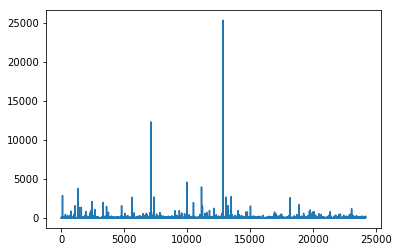

In [68]:
plt.plot(accuracy)

In [115]:
percent = pd.DataFrame({'true': 100*y_test, 'pred': 100*np.squeeze(y_pred)})
percent['diff'] = abs(percent['true'] - percent['pred'])
percent.head()

,pred,true,diff
0,-3.317960,-7.567688,4.249728
1,66.602531,57.527945,9.074586
2,-7.961211,-7.960199,0.001012
3,-6.208723,-8.955224,2.746501
4,-6.558756,-10.855405,4.296650


In [117]:
percent[percent['diff']>100]

,pred,true,diff
10,99.984138,208.738523,108.754384
42,99.997177,224.339425,124.342248
96,99.999985,2972.727273,2872.727288
141,99.999695,237.981799,137.982104
326,99.999733,553.497942,453.498209
408,99.453354,-59.595888,159.049242
414,99.999443,240.000000,140.000557
480,99.999939,-12.820513,112.820452
488,99.994675,315.360131,215.365457
497,99.950996,421.914250,321.963254


#### Check the correlation of 'diff' and 'true', since the prediction might be cater for some coins with price fluctuate little

(0, 100)

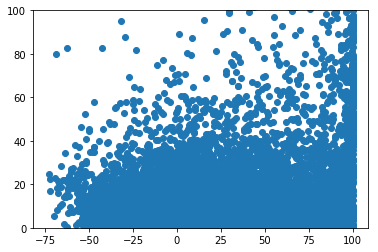

In [138]:
fig, ax = plt.subplots()
ax.scatter(percent['pred'], percent['diff'])
ax.set_ylim([0, 100])

### Fluctuate too much, the whole model can not be used

In [119]:
percent['acc'] = percent.apply(lambda row: 1 if row['true']*row['pred']>0 else 0, axis=1)
percent.head()

,pred,true,diff,acc
0,-3.317960,-7.567688,4.249728,1
1,66.602531,57.527945,9.074586,1
2,-7.961211,-7.960199,0.001012,1
3,-6.208723,-8.955224,2.746501,1
4,-6.558756,-10.855405,4.296650,1


In [121]:
print 'Accuracy is', float(np.sum(percent['acc']))/len(percent)

Accuracy is 0.885852488837


#### But this increase is compare to the price 10 days ago, which does not make much sense

In [72]:
from scipy import stats

In [73]:
stats.describe(np.array(accuracy))

DescribeResult(nobs=24188, minmax=(0.0010116035072504914, 25331.91501282631), mean=16.066744866303456, variance=39634.720432208211, skewness=96.84532818581582, kurtosis=11441.37925988595)

In [110]:
for i in range(1, 10):
    perc = i/10.
    print '{} quantile of accuracy is {}'.format(perc, np.percentile(np.array(accuracy), perc))

0.1 quantile of accuracy is 0.0078182348772
0.2 quantile of accuracy is 0.0140293577406
0.3 quantile of accuracy is 0.0194824157545
0.4 quantile of accuracy is 0.0289834911443
0.5 quantile of accuracy is 0.0362555015672
0.6 quantile of accuracy is 0.0432046082585
0.7 quantile of accuracy is 0.0513833025298
0.8 quantile of accuracy is 0.0592428869947
0.9 quantile of accuracy is 0.0670042706014


### Now turn the model into a classification problem, predict if increase or not price

#### Get the close increase of all test set

In [88]:
prev_day_close = X_test[:, -1, -2]

In [93]:
close_price = pd.DataFrame({'prev_day_close': prev_day_close, 
                            'today_actual_close': y_test, 'today_pred_close': np.squeeze(y_pred)})
close_price.head()

,prev_day_close,today_actual_close,today_pred_close
0,-0.039503,-0.075677,-0.033180
1,0.648792,0.575279,0.666025
2,-0.079602,-0.079602,-0.079612
3,-0.059701,-0.089552,-0.062087
4,-0.081081,-0.108554,-0.065588


In [100]:
close_price['actual_increase'] = (close_price['today_actual_close'] - close_price['prev_day_close']).apply(lambda x: 1 if x>0 else 0)
close_price['pred_increase'] = (close_price['today_pred_close'] - close_price['prev_day_close']).apply(lambda x: 1 if x>0 else 0)
close_price.head()

,prev_day_close,today_actual_close,today_pred_close,actual_increase,pred_increase
0,-0.039503,-0.075677,-0.033180,0,1
1,0.648792,0.575279,0.666025,0,1
2,-0.079602,-0.079602,-0.079612,0,0
3,-0.059701,-0.089552,-0.062087,0,0
4,-0.081081,-0.108554,-0.065588,0,1


In [104]:
correct = 1
for i in range(len(close_price)):
    if close_price.loc[i, 'actual_increase'] == close_price.loc[i, 'pred_increase']:
        correct += 1
print 'Classification accuracy is', float(correct)/len(close_price)

Classification accuracy is 0.511286588391


#### No use at all !!!

## Use the first window_len days to predict if the coming day price will go up

In [143]:
class crypto():
    def __init__(self):
        self.train_X = []
        self.train_y = []
    
    def create_input(self, dat, window_len=3):
        # input dat: data frame
        # output train_X: array (samples, time_step, num_features)
        # output train_y: array labels(close price)
        dat = dat.sort_values(by='Date').reset_index(drop=True)
        dat = dat.drop('Date', axis=1)
        cols = dat.columns
        for i in range(len(dat)-window_len):
            temp_dat = dat[i:(i+window_len)].copy().reset_index(drop=True)
            # normalize data by computing the increase percentage: (X2-X1)/X1
            for col in cols:
                temp_dat[col] = temp_dat[col]/temp_dat.loc[0, col] - 1
            self.train_X.append(temp_dat)
            # if the price goes up, up -> 1 else -> 0
            price_diff = dat.loc[(i+window_len), 'Close']-dat.loc[(i+window_len-1), 'Close']
            self.train_y.append(1 if price_diff > 0 else 0)
    
    def read_file(self, path, window_len=3):
        for root, dirs, files in os.walk(path):
            for file in files:
                print 'Processing file', file
                dat = pd.read_csv(os.path.join(path, file))
                dat.drop(dat.columns[0], axis=1, inplace=True)  # drop index
                try:
                    self.create_input(dat, window_len=window_len)  
                except:
                    print 'Error file', file
                    pass
    
    def to_array(self):
        # return array train_X and train_y
        # convert data set to array
        self.train_X = [np.array(self.train_X[i]) for i in range(len(self.train_X))]
        self.train_y = [np.array(self.train_y[i]) for i in range(len(self.train_y))]
        
        return np.array(self.train_X), np.array(self.train_y)

In [145]:
crypto_2 = crypto()

In [146]:
crypto_2.read_file(path, 10)

Processing file Skycoin.csv
Processing file DECENT.csv
Processing file IOTA.csv
Processing file WhiteCoin.csv
Processing file Bitcoin-Private.csv
Processing file Syscoin.csv
Processing file Achain.csv
Processing file byteball.csv
Processing file Counterparty.csv
Processing file metaverse.csv
Processing file DigitalNote.csv
Processing file Asch.csv
Processing file nav-coin.csv
Processing file MinexCoin.csv
Processing file Nano.csv
Processing file .DS_Store
Error file .DS_Store
Processing file Ardor.csv
Processing file DigiByte.csv
Processing file TokenPay.csv
Processing file Bitcoin-Diamond.csv
Processing file Gulden.csv
Processing file SelfSell.csv
Processing file Monero.csv
Processing file BOScoin.csv
Processing file ZenCash.csv
Processing file Steem.csv
Processing file Primecoin.csv
Processing file Ravencoin.csv
Processing file Hshare.csv
Processing file BitBay.csv
Processing file Blocknet.csv
Processing file Litecoin-Cash.csv
Processing file Peercoin.csv
Processing file SaluS.csv
Pr

In [147]:
train_X = crypto_2.train_X
train_y = crypto_2.train_y

In [152]:
train_X, train_y = crypto_2.to_array()

In [155]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3)

In [156]:
neurons = 512                 
activation_function = 'tanh'  
loss = 'binary_crossentropy'                  
optimizer = 'adam'              
dropout = 0.25                 
batch_size = 128               
epochs = 2      
output_size=1

model = Sequential()
model.add(LSTM(neurons, return_sequences=True, 
               input_shape=(X_train.shape[1], X_train.shape[2]), activation=activation_function))
model.add(Dropout(dropout))
model.add(LSTM(neurons, return_sequences=True, activation=activation_function))
model.add(Dropout(dropout))
model.add(LSTM(neurons, activation=activation_function))
model.add(Dropout(dropout))
model.add(Dense(units=output_size, activation='sigmoid'))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 10, 512)           1060864   
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 512)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 10, 512)           2099200   
_________________________________________________________________
dropout_8 (Dropout)          (None, 10, 512)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total para

### Train with only 2 epochs

In [157]:
history = model.fit(X_train, y_train, epochs=epochs, 
                    batch_size=batch_size, verbose=1, validation_data=(X_test, y_test), shuffle=True)

Train on 56438 samples, validate on 24188 samples
Epoch 1/2
56438/56438 [==============================] - 758s 13ms/step - loss: 0.6922 - acc: 0.5262 - val_loss: 0.6942 - val_acc: 0.5232
Epoch 2/2
56438/56438 [==============================] - 606s 11ms/step - loss: 0.6912 - acc: 0.5292 - val_loss: 0.6911 - val_acc: 0.5249


In [158]:
gc.collect()

567